In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os




In [2]:
dataset= "cifar10"
run= "19-05"

In [103]:
def get_scores(algorithm, run, dataset, n_epochs, rad, sd):
    if algorithm=="pc" or algorithm=="random" or algorithm=="full":
        rad=0.0
    run_path= f"./{run}/{dataset}/{n_epochs}_4_{rad}_{sd}/"
    if algorithm=="full":
        scores= pd.read_csv(run_path +"full.csv", index_col=0)["full_scores"].to_numpy()
    else:
        scores= pd.read_csv(run_path +f"{algorithm}_scores.csv", index_col=0)[f"{algorithm}_scores"].to_numpy()

    return scores.reshape(-1,1)

def get_queries(algorithm, run, dataset, n_epochs, rad, sd):
    if algorithm=="pc" or algorithm=="random" or algorithm=="full":
        rad=0.0
    run_path= f"./{run}/{dataset}/{n_epochs}_4_{rad}_{sd}/"
    queries= pd.read_csv(run_path +f"{algorithm}_queries.csv", index_col=0)[f"{algorithm}_queries"].to_numpy()
    return queries.reshape(-1,1)

def get_degrees(algorithm, run, dataset, n_epochs, rad, sd):
    assert(algorithm=="pc" or algorithm=="adpc")
    if algorithm=="pc":
        rad=0.0
    run_path= f"./{run}/{dataset}/{n_epochs}_4_{rad}_{sd}/"
    df= pd.read_csv(run_path +f"{algorithm}_degrees.csv", index_col=0)
    degrees= df[f"{algorithm}_degrees"].to_numpy()
    options=df[f"{algorithm}_options"].to_numpy()
    return degrees.reshape(-1,1), options.reshape(-1,1)

def get_transition(algorithm, run, dataset, n_epochs, rad, sd):
    assert(algorithm=="pc" or algorithm=="adpc")
    if algorithm=="pc":
        rad=0.0
    run_path= f"./{run}/{dataset}/{n_epochs}_4_{rad}_{sd}/"
    df= pd.read_csv(run_path +f"{algorithm}_degrees.csv", index_col=0)
    degrees= df[f"{algorithm}_degrees"].to_numpy()
    options=df[f"{algorithm}_options"].to_numpy()
    if algorithm=="pc":
        id_min= np.where(degrees==0)[0]
        id_max= None
    if algorithm=="adpc":
        id_min= np.where(degrees==0)[0]
        id_max= np.where(degrees>0)[0][-1]
    return id_min, id_max

def get_radiuses(algorithm, run, dataset, n_epochs, rad, sd):
    assert(algorithm=="pc" or algorithm=="adpc")
    if algorithm=="pc":
        rad=0.0
    run_path= f"./{run}/{dataset}/{n_epochs}_4_{rad}_{sd}/"
    df= pd.read_csv(run_path +f"{algorithm}_radiuses.csv", index_col=0)
    radiuses=df[f"{algorithm}_radiuses"].to_numpy()
    return radiuses.reshape(-1,1)



In [72]:
def plot_scores(run, dataset, n_epochs, rad, n_seeds, relative= False):
    # Get points for the x axis
    eval_freq = np.concatenate((np.repeat(1, 100), np.repeat(2, 50),
                                    np.repeat(5, 20), np.repeat(10, 20), np.repeat(20, 25),
                                   np.repeat(50, 20), np.repeat(100,40),
                                    np.repeat(200,20), np.repeat(500, 10)))
    if dataset=="cifar100":
        eval_freq= np.concatenate((eval_freq, np.repeat(500, 20)))
    idx= np.cumsum(eval_freq)
    n_eval= len(idx)

    # Get the scores
    pc_scores, random_scores = np.zeros(shape= (n_eval, 0)), np.zeros(shape= (n_eval, 0))
    for sd in np.arange(1, n_seeds+1):
        pc_scores = np.concatenate((pc_scores, get_scores("pc", run, dataset, n_epochs, rad, sd)[:n_eval]), axis=1)
        random_scores = np.concatenate((random_scores, get_scores("random", run, dataset, n_epochs, rad, sd)[:n_eval]), axis=1)
    full_scores = get_scores("full", run, dataset, n_epochs, rad, sd)[:n_eval]
    min_length= n_eval
    for sd in np.arange(1, 3):
        adpc_scores = get_scores("adpc", run, dataset, n_epochs, rad, sd)
        if len(adpc_scores)<min_length:
            min_length= len(adpc_scores)
    adpc_scores= np.zeros(shape=(min_length, 0))
    for sd in np.arange(1, 3):
        adpc_scores = np.concatenate((adpc_scores, get_scores("adpc", run, dataset, n_epochs, rad, sd)[:min_length]), axis=1)

    pc_mean, pc_std = pc_scores.mean(1), pc_scores.std(1)
    random_mean, random_std = random_scores.mean(1), random_scores.std(1)
    adpc_mean, adpc_std = adpc_scores.mean(1), adpc_scores.std(1)
    full_scores= full_scores.squeeze()
    m= len(adpc_mean)
    if m< len(idx):
        print(f"Run not fully completed, current number of queries for the run is {idx[m-1]}")

    if relative:
        pc_mean, random_mean, adpc_mean = pc_mean[:m]-full_scores[:m], random_mean[:m]-full_scores[:m],\
                                          adpc_mean-full_scores[:m]
    else:
        pc_mean, random_mean, adpc_mean = pc_mean[:m], random_mean[:m], adpc_mean
    pc_std, random_std = pc_std[:m], random_std[:m]
    idx = idx[:m]


    plt.plot(idx, random_mean, color= "green", label= "Random")
    plt.fill_between(idx, random_mean-random_std, random_mean+random_std, alpha=0.5, color= "green")

    plt.plot(idx, pc_mean, color= "blue", label= "PC")
    plt.fill_between(idx, pc_mean-pc_std, pc_mean+pc_std, alpha=0.5, color= "blue")

    plt.plot(idx, adpc_mean, color= "red", label= "Adaptive PC")
    plt.fill_between(idx, adpc_mean-adpc_std, adpc_mean+adpc_std, alpha=0.5, color= "red")
    if not relative:
        plt.plot(idx, full_scores[:m], label= "Oracle")


In [73]:
# Check that all of the runs were completed for the benchmarks
for sd in [1,2,3,4,5,6,7,8,9,10]:
    for n_epochs in [100, 200, 400, 800, 1000]:
        adpc_scores = get_scores("pc", run, dataset, n_epochs, 0.0, sd)
        if len(adpc_scores)<315:
            print(n_epochs, sd, len(adpc_scores))

In [74]:
# Check that all of the runs were completed for the adaptive runs
run= "19-05"
for sd in [1,2]:
    for rad in [0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]:
        for n_epochs in [100,200,400,800,1000]:
            adpc_scores = get_scores("adpc", run, dataset, n_epochs, rad, sd)
            if len(adpc_scores)<305:
                adpc_queries = get_queries("adpc", run, dataset, n_epochs, rad, sd)
                print(n_epochs, rad, sd, len(adpc_scores), len(adpc_queries))


100 0.85 1 294 9900
100 0.9 1 275 6000
200 0.9 1 300 12700
100 0.85 2 295 10200
100 0.9 2 252 3700
200 0.9 2 297 11300
400 0.9 2 304 14600


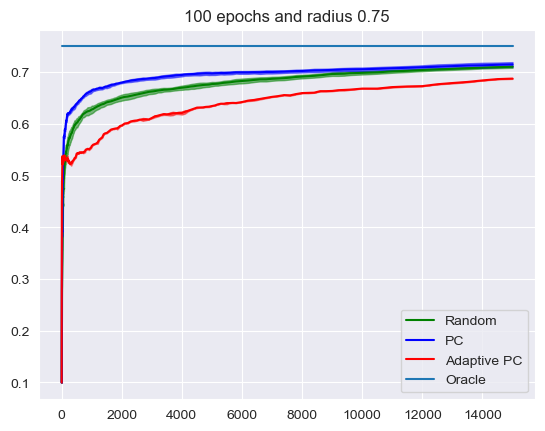

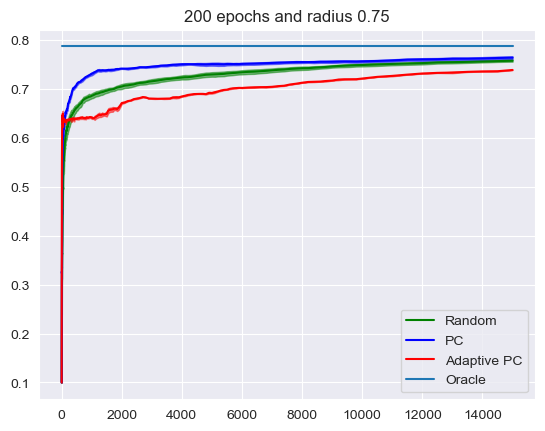

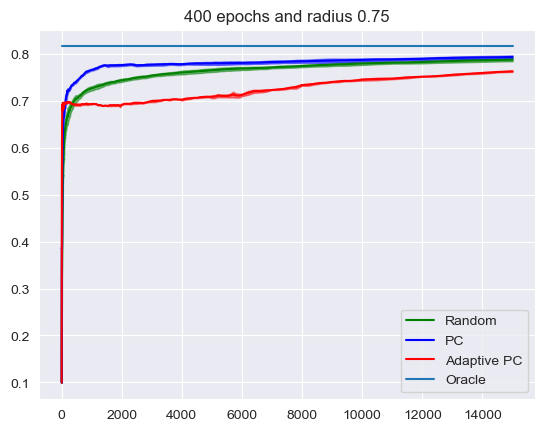

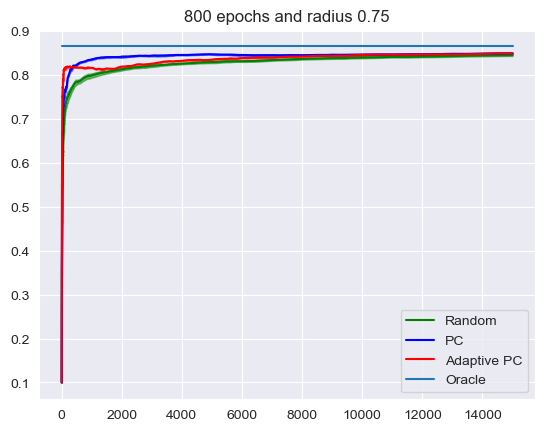

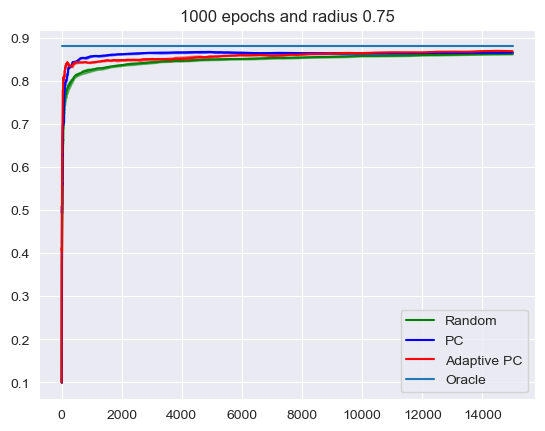

In [118]:
# for rad in [0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]:
rad= 0.75
relative= False
for n_epochs in [100, 200, 400, 800, 1000]:
    plot_scores(run, dataset, n_epochs, rad, n_seeds=10, relative=relative)
    plt.legend()
    plt.title(label= f"{n_epochs} epochs and radius {rad}")
    # plt.xscale("log")
    plt.show()
#Probcover radiuses: [0.45, 0.5, 0.53, 0.58, 0.63]

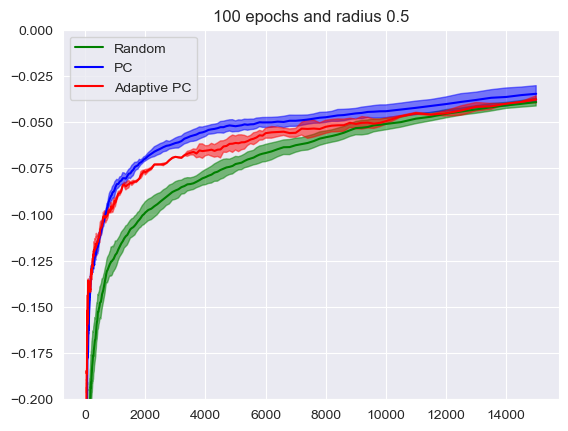

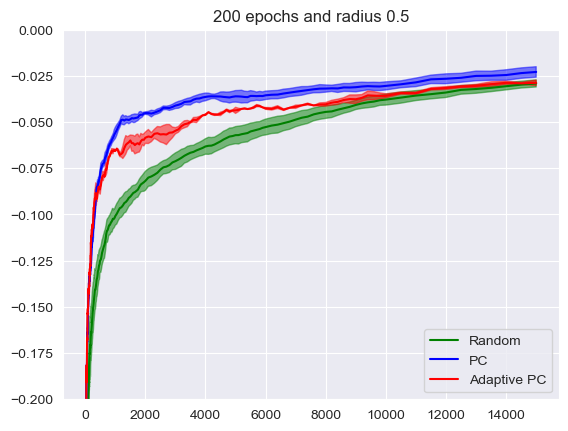

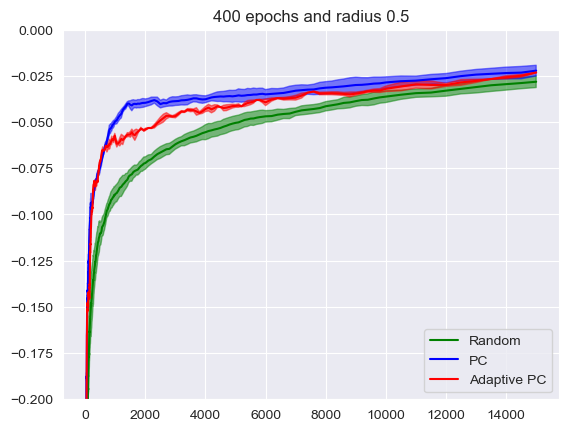

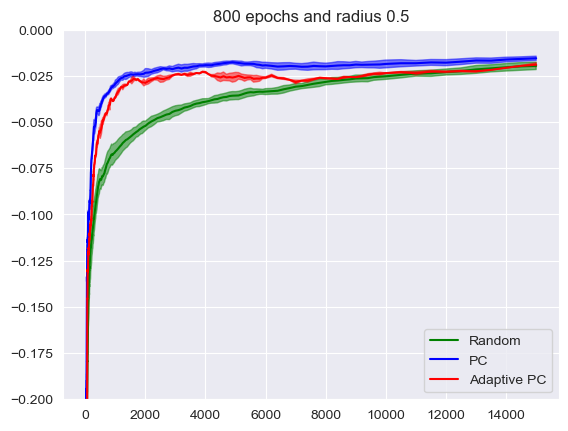

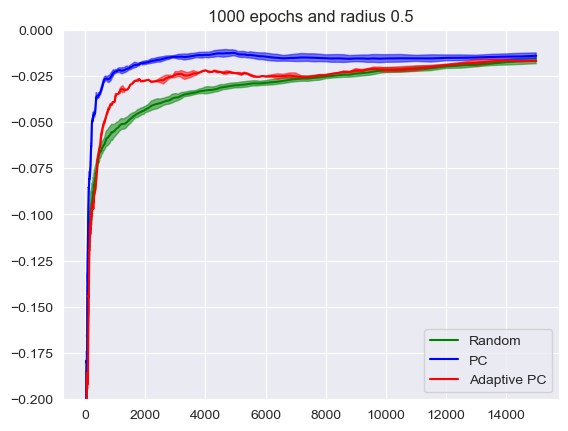

In [97]:
# for rad in [0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]:
rad= 0.5
relative= True
for n_epochs in [100,200,400,800,1000]:
    plot_scores(run, dataset, n_epochs, rad, n_seeds=10, relative=relative)
    plt.legend()
    plt.title(label= f"{n_epochs} epochs and radius {rad}")
    plt.ylim(-0.2, 0)
    plt.show()


In [95]:
def plot_degrees(run, dataset, n_epochs, rad, type):
    # Get points for the x axis
    eval_freq = np.concatenate((np.repeat(1, 100), np.repeat(2, 50),
                                    np.repeat(5, 20), np.repeat(10, 20), np.repeat(20, 25),
                                   np.repeat(50, 20), np.repeat(100,40),
                                    np.repeat(200,20), np.repeat(500, 10)))
    if dataset=="cifar100":
        eval_freq= np.concatenate((eval_freq, np.repeat(500, 20)))
    idx= np.cumsum(eval_freq)
    idx= np.arange(1, idx.max()+1)

    # Get the scores
    adpc_deg, adpc_options= get_degrees("adpc", run, dataset, n_epochs, rad, sd=1)
    pc_deg, pc_options= get_degrees("pc", run, dataset, n_epochs, rad, sd=1)
    m= len(adpc_deg)
    idx, adpc_deg, adpc_options, pc_deg, pc_options= idx[:m], adpc_deg[:m], adpc_options[:m], pc_deg[:m], pc_options[:m]

    if m< len(idx):
        print(f"Run not fully completed, current number of queries for the run is {idx[m-1]}")

    if type=="degrees":
        plt.plot(idx, adpc_deg, color= "green", label= "Adaptive PC")
        plt.plot(idx, pc_deg, color= "blue", label= "PC")
        plt.title(label= "Number of degrees of the selected query")
    if type=="options":
        plt.plot(idx, adpc_options, color= "green", label= "Adaptive PC")
        plt.plot(idx, pc_options, color= "blue", label= "PC")
        plt.title(label= "Number of options for queries with the same out-degree")
    plt.legend()
    plt.show()

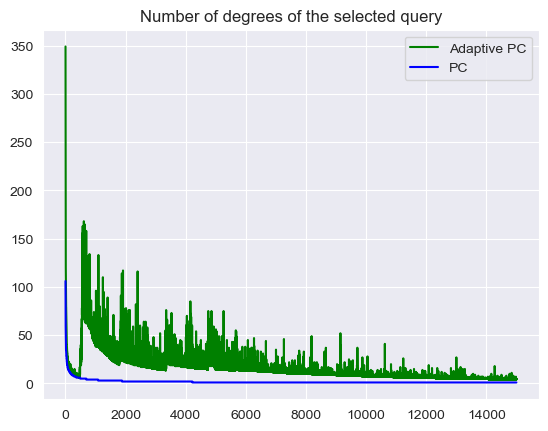

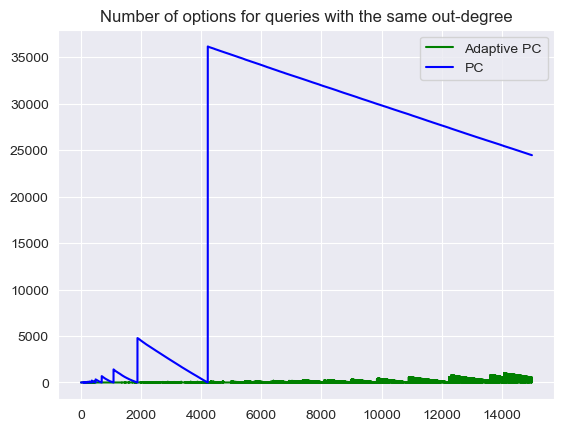

In [94]:
run= "19-05"
dataset= "cifar10"
rad= 0.55
n_epochs=100
plot_degrees(run, dataset, n_epochs, rad, "degrees")
plot_degrees(run, dataset, n_epochs, rad, "options")